# Bayesian Approach to Estimating Piecewise Linear Parameters

This project is a proof of concept for a fully Bayesian approach to a common regression problem.  For this particular project I assume we have knowledge of all relevant prior distributions based on a larger population.

In [1]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from scipy.stats import probplot
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import gaussian_kde

The piecewise linear model for this example contains a single change point with a negative slope to the left of the change, and a positive slope to the right of the change.  The function to plot points for a given set of parameters is defined below.

In [2]:
def PWL(x, params):
    slopes, intercepts = [params[1], params[2]], [params[3], params[4]]
    if x < intercepts[0]:
        return(slopes[0] * x + intercepts[1] - intercepts[0] * slopes[0])
    else:
        return(slopes[1] * x + intercepts[1] - intercepts[0] * slopes[1])

For the Bayesian approach, each parameter must have a well defined probability distribution function and sampling function.  The Param class below allows for handling more complicated distributions in a standard way.

In [3]:
class Param:
    def __init__(self, name, sample_fun, pdf_fun, minmax, is_neg=False, step = 0.1):
        self.sample_fun = sample_fun
        self.pdf_fun = pdf_fun
        self.minmax = minmax
        self.prange = np.arange(self.minmax[0], self.minmax[1], step)
        self.name = name
        self.step = step
        self.is_neg = is_neg
    def sample(self):
        if self.is_neg:
            return -self.sample_fun()
        return self.sample_fun()
    def pdf(self, x):
        if self.is_neg:
            return self.pdf_fun(-x)
        return self.pdf_fun(x)

As stated earlier, the prior distributions for each parameter are well known.

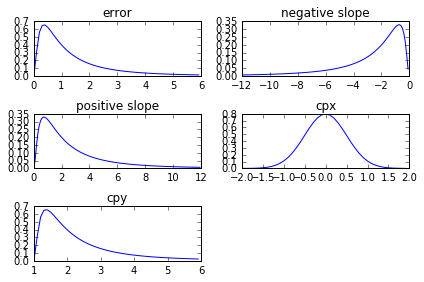

In [4]:
error_dist = lognorm(s=1, loc = 0.0, scale = 1)
slope_dist = lognorm(s=1, scale = 2)
cpx_dist   = norm(loc = 0, scale = 0.5)
cpy_dist   = lognorm(s=1, loc=1)
    
error     = Param("error", error_dist.rvs, error_dist.pdf, [0.01, 6])
neg_slope = Param("negative slope", slope_dist.rvs, slope_dist.pdf, [-12, -0.01], True)
pos_slope = Param("positive slope", slope_dist.rvs, slope_dist.pdf, [0.01, 12])
cpx       = Param("cpx", cpx_dist.rvs, cpx_dist.pdf, [-2, 2])
cpy       = Param("cpy", cpy_dist.rvs, cpy_dist.pdf, [1.01, 6])

params_list = [error, neg_slope, pos_slope, cpx, cpy]

fig1 = plt.figure()
for i in range(len(params_list)):  
    ax = fig1.add_subplot(3,2,i+1)
    fig1.tight_layout()
    ax.plot(params_list[i].prange, params_list[i].pdf(params_list[i].prange))
    ax.set_title(params_list[i].name)
plt.show()

We need some fake data along with some sampled parameters.

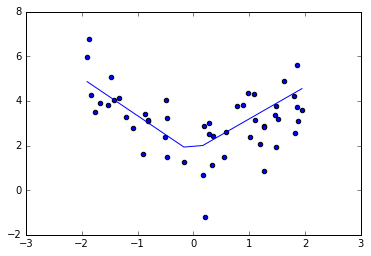

In [5]:
n_data = 50

rand_x = [uniform(loc=-2, scale=4).rvs() for i in range(n_data)]
rand_params = [param.sample() for param in params_list]
y = [PWL(x, rand_params) + norm(loc=0, scale=rand_params[0]).rvs() for x in rand_x]
plt.scatter(rand_x, y)
plt.plot(np.sort(rand_x), [PWL(x, rand_params) for x in np.sort(rand_x)])

Later on I will be using Gibbs sampling to estimate the parameters.  This requires a definition of the product of the priors, the likelihood function, and the posterior function.

In [6]:
def priors(params):
    return np.product([params_list[i].pdf(params[i]) for i in range(len(params_list))])

def likelihood(x_list, y_list, params):
    return np.product([norm(loc=PWL(x, params), scale=params[0]).pdf(y) for x, y in zip(x_list, y_list)])

def posterior(x, y, params):
    return priors(params) * likelihood(x, y, params)

To implement the Gibbs sampler there are a number of pieces.  For each sample step, we will select a random parameter to update.  Updating involves drawing a random value from the current posterior distribution.  This implementation is a brute force method, typically one would try to factor out the conditional posteriors for each random variable and draw a sample from that distribution (this is the same thing, but without having done the extra bit of math so it will take longer than it should).

In [30]:
def gibbs_sampled_list(x, y, n_samples, initial_params = None):
    sampled_params = [[param.sample() for param in params_list] or initial_params] # Our list of gibbs sampled parameters
    errors = [] # List of the total error at each step
    i = 1
    while i < n_samples:
        params = sampled_params[-1][:] # Always use the latest set of parameters to update on
        index  = randint(0, len(params_list)).rvs() # Decide which parameter to update
        candidate_params = sample_step(x, y, params, index) # Draws a new value from the posterior
        if not candidate_params[index] == params[index]: # In some cases the update may fail
            sampled_params.append(candidate_params)
            errors.append(np.sum([(yi-PWL(xi, candidate_params))**2 for xi, yi in zip(x, y)]))
            i += 1
    plt.scatter(range(len(errors)), errors)
    plt.show()
    return sampled_params

def sample_step(x, y, params, index):
    post_cdf   = posterior_cdf(x, y, params, index) # Get the cumulative distribution function for the current posterior
    if post_cdf[0] is None: # In some cases the cdf isn't properly generated
        return params
    new_params = params[:]
    rand = uniform(0,1).rvs() # Draw a random value, the cdf maps a value drawn from the uniform distribution to one drawn from the posterior distribution
    for i in range(1, len(params_list[index].prange)): # This loop is an implemention of linear interpolation
        if rand < post_cdf[i]:
            dy, dx    = post_cdf[i] - post_cdf[i-1], params_list[index].prange[i] - params_list[index].prange[i-1]
            slope     = dy/dx
            intercept = post_cdf[i-1] - slope * params_list[index].prange[i-1]
            if slope == 0:
                new_params[index] = params_list[index].prange[i]
            else:
                new_params[index] = (rand - intercept) / slope
            break
    return new_params

def posterior_cdf(x, y, params, index):
    post_cdf = [0]
    for value in params_list[index].prange: # Loop over the parameter range and calculate the cumulative distribution function of the posterior
        new_params = params[:]
        new_params[index] = value
        post_cdf.append(post_cdf[-1] + posterior(x, y, new_params))
    if post_cdf[-1] == 0: # Sometimes the posterior is zero for the whole range
        return [None]
    return post_cdf / post_cdf[-1] # Return the normalized cdf

Typically one needs to allow for a burn in period when using MCMC methods.  The burn in period allows the Markov Chain to get into a stationary state (it needs some iterations to start drawing representative samples from a random start).  I actually cheat here a little bit by starting the sampler in the most probable state.

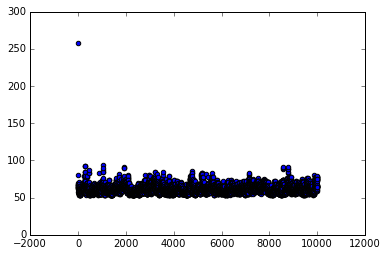

In [33]:
sampled_list = gibbs_sampled_list(x=rand_x, y=y, n_samples=10000, initial_params = rand_params)

In [34]:
def get_one_dim_pdf(samples_list, index):
    return [sample[index] for sample in samples_list]

def get_estimated_params(samples_list):
    params = []
    for index in range(len(samples_list[0])):
        densities = list(gaussian_kde(get_one_dim_pdf(samples_list, index))(params_list[index].prange))
        params.append(params_list[index].prange[densities.index(max(densities))])
        params
    return params

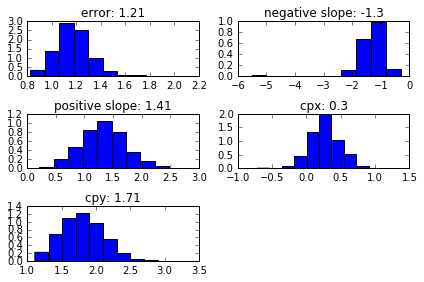

In [39]:
fig2 = plt.figure()
sub_list = sampled_list
estimated_params = get_estimated_params(sub_list) 

for index in range(len(params_list)):  
    ax = fig2.add_subplot(3,2,index+1)
    fig2.tight_layout()
    ax.hist(get_one_dim_pdf(sub_list, index = index), normed=True)
    ax.set_title(str(params_list[index].name) + ": " + str(estimated_params[index]))

plt.show()

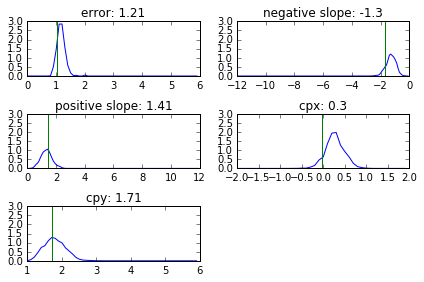

In [40]:
fig3 = plt.figure()
estimated_params = get_estimated_params(sub_list)    

for index in range(len(params_list)):  
    ax = fig3.add_subplot(3,2,index+1)
    fig3.tight_layout()
    density = gaussian_kde(get_one_dim_pdf(sub_list, index))
    densities = list(gaussian_kde(get_one_dim_pdf(sub_list, index))(params_list[index].prange))
    ax.plot(params_list[index].prange, densities)
    ax.plot((rand_params[index], rand_params[index]), (0, 3), "green")
    ax.set_title(str(params_list[index].name) + ": " + str(estimated_params[index]))

plt.show()

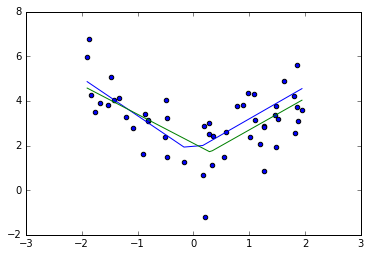

In [41]:
plt.scatter(rand_x, y)
plt.plot(np.sort(rand_x), [PWL(x, rand_params) for x in np.sort(rand_x)])
plt.plot(np.sort(rand_x), [PWL(x, estimated_params) for x in np.sort(rand_x)])